# 🎶 Predicting Lyrics
<hr>
<br>
<b> Group name: <strike>AA</strike> <i>My Machine Learning Romance</i> </b> <br>
- Fiorella Tenorio <br>
- Katja Wittfoth <br>
- Rebecca Reilly <br>
- Victoria Suarez <br>
- Viviana Márquez <br>

<br>
<img src='USF.png', style="width:200px;" align="left">
Friday, December 7th, 2018. <br>
<b> MSDS 621 </b> - Introduction to Machine Learning 

## Goal 
<center>
    <big>🏆<br>
    Predict genre based on lyrics</big><br><br>
</center> 

## Agenda
- Introduction to our dataset
- Supervised learning
- Unsupervised learning
- <i>Are you smarter than a ML algorithm?</i>

## Workflow Pipeline
<center>
    <img src="workflow3.png" style="height:500px">
</center> 

In [145]:
# Libraries
import warnings
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
import seaborn as sns
sns.set()

warnings.filterwarnings('ignore')

In [146]:
# Read data
df = pd.read_csv('../lyrics.csv')

In [147]:
# Clean data
def clean_lyrics(text):
    text = re.sub('\n', ' ', text)  # removes new lines
    text = re.sub('\d', '', text)  # removes numbers
    text = re.sub('\t', '', text)  # removes tabs
    text = re.sub('[^A-Za-z ]', '', text)  # removes special character
    text = re.sub('\[Verse\s*\d*:]', ' ', text)  # remove verse indicators
    text = re.sub('\s+', ' ', text)
    words = text.split(" ")
    words = [w for w in words if len(w) > 2]  # removes a, an, to, at, be, ...
    return ' '.join(words)


df = df[pd.notnull(df['lyrics'])]
df = df[df['genre'] != 'Not Available']
df = df[df['genre'] != 'Other']
df['lyrics_clean'] = df.lyrics.apply(clean_lyrics)

df_clean = df[(df.genre == 'Country') | (df.genre == 'Metal') |
              (df.genre == 'Hip-Hop') | (df.genre == 'Jazz') | (df.genre == 'Electronic')]

df_clean = df_clean.sample(frac=1)  # shuffle

## 📊 Get data and pre-process

- 380,000+ lyrics  from MetroLyrics in <a href="https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics">Kaggle</a>

#### 🛁 Cleaning 
- Remove: `Null` lyrics, "Not available" genre, punctuation, numbers, symbols, spaces, stop words.
- Shuffle data.
- **Genres**: Country, Metal, Hip-Hop, Jazz, Electronic.

In [148]:
df_clean.head()

,index,song,year,artist,genre,lyrics,lyrics_clean
74104,74104,bravehearted,2006,bravehearts,Hip-Hop,"[chorus]\nBrave,Brave,Brave,Brave,Brave, Brave...",chorus BraveBraveBraveBraveBrave BraveHeart te...
42713,42713,don-t-worry-mary-jblige,2005,game,Hip-Hop,[Mary]\nCan't wait til we make real love becau...,Mary Cant wait til make real love because thes...
51504,51504,we-outchea,2013,ace-hood,Hip-Hop,"Real life\nAce Hood, yea\nWe the motherfuckin'...",Real life Ace Hood yea the motherfuckin best h...
311982,311982,4-minus-3-equals-zero,2006,george-strait,Country,You always said you loved me\nAnd I always bel...,You always said you loved And always believed ...
339670,339670,kain,2007,blind-myself,Metal,"Kin, csd vre felkilt hozzm a Fldrl lgy teht tk...",Kin csd vre felkilt hozzm Fldrl lgy teht tkozo...


## Summary of Data

In [149]:
df_clean.groupby('genre').count()

,index,song,year,artist,lyrics,lyrics_clean
genre,,,,,,
Country,14387,14387,14387,14387,14387,14387
Electronic,7966,7966,7966,7966,7966,7966
Hip-Hop,24850,24850,24850,24850,24850,24850
Jazz,7971,7970,7971,7971,7971,7971
Metal,23759,23759,23759,23759,23759,23759


<center>
    <img src="pie.png" style="height:500px;">
</center> 

## 👠 Modeling

### ✂️ Splitting data

In [150]:
train, test = train_test_split(df_clean, test_size=0.2)
train_lyrics = train['lyrics_clean']
train_genre = train['genre']
test_lyrics = test['lyrics_clean']
test_genre = test['genre']

### 📊 Supervised models

- Pipelines: 
   - Vectorizers: CountVectorizer, TfidfVectorizer
   - Estimators: MultinomialNB, LogisticRegression, LinearSVC

- GridSearch

In [151]:
pipe_lr_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                           lowercase=False,
                           analyzer='word')),
    ('lr', LogisticRegression())
])

pipe_lr_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              lowercase=False,
                              analyzer='word')),
    ('lr', LogisticRegression())
])

pipe_nb_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                           lowercase=False,
                           analyzer='word')),
    ('nb', MultinomialNB())
])

pipe_nb_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              lowercase=False,
                              analyzer='word')),
    ('nb', MultinomialNB())
])

pipe_svc_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                           lowercase=False,
                           analyzer='word')),
    ('svc', LinearSVC())
])

pipe_svc_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              lowercase=False,
                              analyzer='word')),
    ('svc', LinearSVC())
])

pipelines = [pipe_lr_cv, pipe_lr_tf, pipe_nb_cv,
             pipe_nb_tf, pipe_svc_cv, pipe_svc_tf]

In [152]:
# Fit pipe
for pipe in pipelines:
    pipe.fit(train_lyrics, train_genre)

In [153]:
methods = []

for pipe in pipelines:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    vect = pipe.steps[0][1].__class__.__name__.split('.')[-1]

    predicted = pipe.predict(test_lyrics)
    accuracy = accuracy_score(predicted, test['genre'])
    conf_mat = confusion_matrix(test['genre'], predicted)

    methods.append([name, vect, accuracy, conf_mat])

methods = pd.DataFrame(methods)
methods.columns = ['Model', 'Vectorizer', 'Accuracy', "Confussion_Matrix"]
methods["Strategy"] = methods["Model"] + " -- " + methods["Vectorizer"]
methods.set_index(["Strategy"], inplace=True)

### Pipelines

In [157]:
methods[["Model", "Vectorizer", "Accuracy"]]

,Model,Vectorizer,Accuracy
Strategy,,,
LogisticRegression -- CountVectorizer,LogisticRegression,CountVectorizer,0.775195
LogisticRegression -- TfidfVectorizer,LogisticRegression,TfidfVectorizer,0.765250
MultinomialNB -- CountVectorizer,MultinomialNB,CountVectorizer,0.730411
MultinomialNB -- TfidfVectorizer,MultinomialNB,TfidfVectorizer,0.622981
LinearSVC -- CountVectorizer,LinearSVC,CountVectorizer,0.734022
LinearSVC -- TfidfVectorizer,LinearSVC,TfidfVectorizer,0.785140


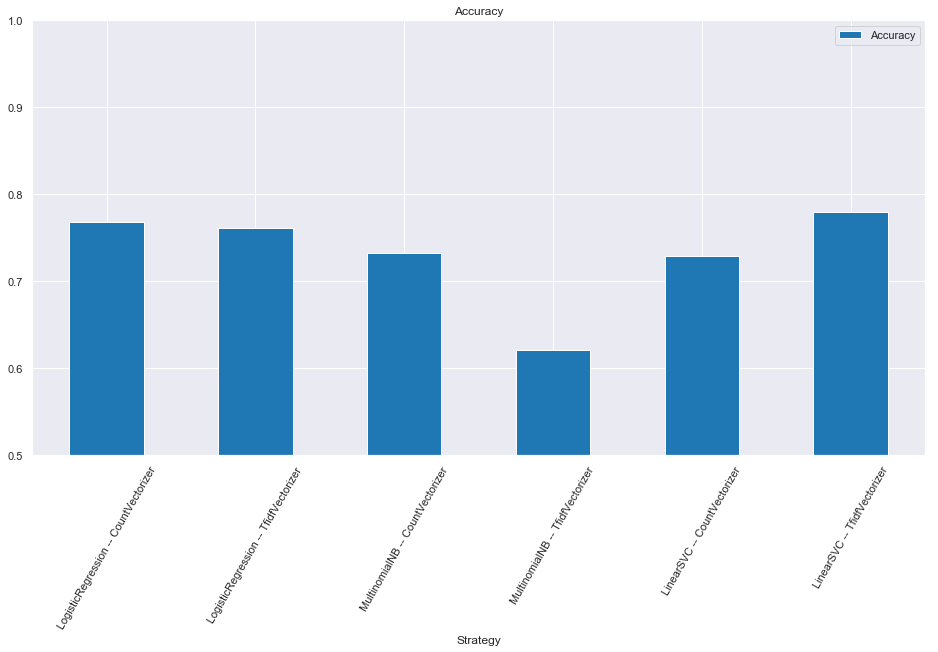

In [114]:
# %matplotlib inline
methods.plot(figsize=(16, 8), kind='bar', title='Accuracy',
             rot=60, ylim=(0.5, 1), colormap='tab10')

In [120]:
def plot_conf_mat(methods):
    """input: data frame with confussion matrix information
    output: plot it"""
    methods = methods.reset_index()
    fig = plt.figure(figsize=(20, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i in range(1, 7):
        ax = fig.add_subplot(2, 3, i)
        sns.heatmap(methods["Confussion_Matrix"].values[i-1],
                    annot=True, fmt='d', ax=ax, cmap="Blues")
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f'Confusion Matrix {methods["Strategy"].values[i-1]}')
        ax.xaxis.set_ticklabels(df_clean.genre.unique(), rotation=60)
        ax.yaxis.set_ticklabels(df_clean.genre.unique(), rotation=60)

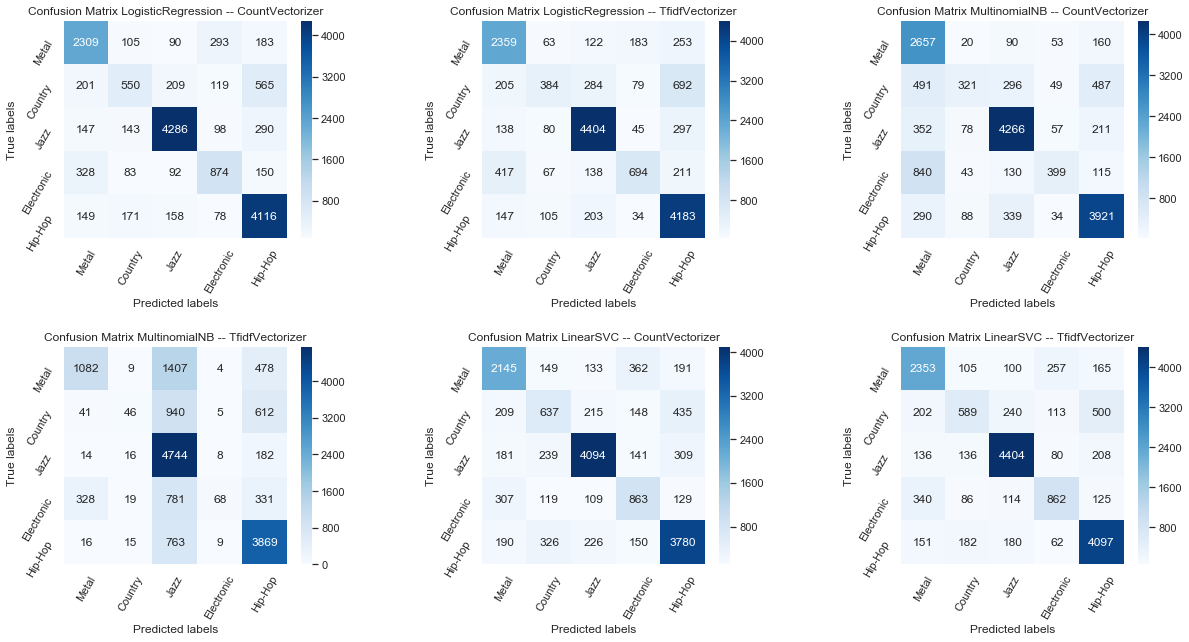

In [121]:
plot_conf_mat(methods)

### Grid Search

In [12]:
grid = {'svc__loss': ['hinge', 'squared_hinge']}

gs = GridSearchCV(pipe_svc_tf,
                  param_grid=grid,
                  scoring='accuracy')

In [13]:
gs.fit(train_lyrics, train_genre)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svc__loss': ['hinge', 'squared_hinge']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [14]:
gs.cv_results_

{'mean_fit_time': array([20.27389606, 10.05352402]),
 'std_fit_time': array([1.2627436 , 0.95058361]),
 'mean_score_time': array([3.25944042, 3.1356039 ]),
 'std_score_time': array([0.18695786, 0.02035713]),
 'param_svc__loss': masked_array(data=['hinge', 'squared_hinge'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svc__loss': 'hinge'}, {'svc__loss': 'squared_hinge'}],
 'split0_test_score': array([0.76764846, 0.77244656]),
 'split1_test_score': array([0.76858758, 0.77234073]),
 'split2_test_score': array([0.76690265, 0.77108376]),
 'mean_test_score': array([0.76771292, 0.77195705]),
 'std_test_score': array([0.00068937, 0.00061898]),
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_train_score': array([0.88564234, 0.9411583 ]),
 'split1_train_score': array([0.88935079, 0.94272751]),
 'split2_train_score': array([0.88614931, 0.94109124]),
 'mean_train_score': array([0.88704748, 0.94165902]),
 'std_train_score': array([0.0

In [15]:
gs.best_estimator_.steps[0][1]  # best model

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
pred = gs.predict(test_lyrics)

In [33]:
accuracy = accuracy_score(pred, test_genre)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7818


#### 🤓 Random Forest with Feature Union

In [30]:
df_sample = df.sample(n=100000)  # sample because it takes too long to run

df_sample = df_sample[pd.notnull(df_sample['lyrics'])]
df_sample = df_sample[df_sample['genre'] != 'Not Available']
df_sample = df_sample[df_sample['genre'] != 'Other']
df_sample['lyrics_clean'] = df_sample.lyrics.apply(clean_lyrics)

df_clean = df_sample[(df_sample.genre == 'Country') | (df_sample.genre == 'Metal') |
                     (df_sample.genre == 'Hip-Hop') | (df_sample.genre == 'Jazz') | (df_sample.genre == 'Electronic')]

In [31]:
X, y = df_clean['lyrics'], df_clean['genre']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
# Refactor from http://michelleful.github.io/code-blog/2015/06/20/pipelines/
class Polarity(BaseEstimator, TransformerMixin):
    """Takes in the lyrics column and outputs polarity score"""

    def __init__(self):
        pass

    def sent_score(self, song):
        """Helper code to compute sentiment"""
        sid = SentimentIntensityAnalyzer()
        if type(song) is str:
            return sid.polarity_scores(", ".join(song.split("\n")))['compound']
        else:
            return 0

    def transform(self, X, y=None):
        """Transform function of this feature extractor"""
        return np.array(X.apply(self.sent_score)).reshape(-1, 1)

    def fit(self, X, y=None):
        """Returns `self` unless there is other functions in train and test"""
        return self

In [38]:
# Refactor from http://michelleful.github.io/code-blog/2015/06/20/pipelines/
class AverageWordLength(BaseEstimator, TransformerMixin):
    """Takes in the lyrics column and outputs average word length"""

    def __init__(self):
        pass

    def average_word_length(self, song):
        """Helper code to compute average word length"""
        return np.mean([len(w) for w in clean_lyrics(song).split(" ")])

    def transform(self, X, y=None):
        """Transform function of this feature extractor"""
        return np.array(X.apply(self.average_word_length)).reshape(-1, 1)

    def fit(self, X, y=None):
        """Returns `self` unless there is other functions in train and test"""
        return self

In [39]:
# features:
countVectorizer = ('vect', CountVectorizer(
    stop_words='english', lowercase=True, analyzer='word'))
tfidf = ('tfidf', TfidfVectorizer())
polarity = ('polarity', Polarity())
avg_len = ('avg_len', AverageWordLength())

In [ ]:
# pipe this features into the pipeline and FeatureUnion
pipeline = Pipeline([
    ('feats', FeatureUnion([avg_len, polarity, countVectorizer])),
    ('clf', RandomForestClassifier(n_estimators=200, n_jobs=-1))
])

In [40]:
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

0.7467434110875493

In [43]:
accuracy_score(pred, y_test)
print(f"Accuracy: {accuracy_score(pred, y_test):.4f}")

Accuracy: 0.7467


# 🏆 Winner supervised model: 

`LinearSVC() with TfidfVectorizer()`

## 🤔 Unsupervised model

- KMeans

In [28]:
# we create the vectorizer
tfidf = TfidfVectorizer(stop_words='english',
                        tokenizer=lambda x: x.split())

# we fit the train data
tf_features = tfidf.fit_transform(train.lyrics_clean)

# and we transform the test data
test_features = tfidf.transform(test.lyrics_clean)

In [42]:
# now, we fit the model
true_k = 11
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(tf_features)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

<center>
    <img src="KMeans_Result.png">
</center> 

<center>
    <big>🇺🇸 &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 
        &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;
         🇺🇸 &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 
        &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 
         🇪🇸 &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;
        &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 
         🇩🇪 &nbsp;&nbsp;&nbsp;  </big>
</center> 

<center>
    <img src="are you smarter.png">
    <big>
    🥊 LinearSVC vs Humans 🥊
    </big>
</center>

In [46]:
def predictor(string, train=train['lyrics_clean'], model=pipe_svc_tf):
    """given a string predict a genre based on the lyrics and best trained model (or a given ones). 
    """
    pred = model.predict([clean_lyrics(string)])
    return list(pred)

In [122]:
mystery1 = """Got a little boom in my big truck
Gonna open up the doors and turn it up
Gonna stomp my boots in the Georgia mud
Gonna watch you make me fall in love
Get up on the hood of my daddy's tractor
Up on the tool box, it don't matter
Down on the tailgate
Girl I can't wait
To watch you do your thing
"""

In [ ]:
predictor(mystery1)

In [95]:
mystery2 = """Oh, sometimes
I get a good feeling, yeah
Get a feeling that I never, 
never, never, never had before, no no
I get a good feeling, yeah
"""

In [ ]:
predictor(mystery2)

In [133]:
mystery3 = """I can't tell you what it really is
I can only tell you what it feels like
And right now there's a steel knife, in my windpipe
I can't breathe, but I still fight, while I can fight
As long as the wrong feels right, it's like I'm in flight
"""

In [ ]:
predictor(mystery3)

<center>
    <img src="bitmojis.png" style="height:600px;">
</center>

In [136]:
people = ['Rebecca pick-up truck Reilly', "Ekaterina money Wittfoth",
          "Fiorella blues Tenorio", "Viviana hyper Márquez"]
for person in people:
    print(f"{person}: {predictor(person)}")

Rebecca pick-up truck Reilly: ['Country']
Ekaterina money Wittfoth: ['Hip-Hop']
Fiorella blues Tenorio: ['Jazz']
Viviana hyper Márquez: ['Electronic']


# Recap ✍️

- We used data on lyrics to predict five genres
- We tried four supervised algorithms
- Concluded that the best one is LinearSVC
- Unsupervised learning showed us that language was the most important feature

# Fun fact
<center>
<img src = "article1.png" style="height:270px;">
<img src = "article2.png" style="height:270px;">
</center>

# Questions

In [138]:
person = "Victoria Suarez"
print(f"{person}: {predictor(person)}")

Victoria Suarez: ['Metal']


<center><img src="bitmoji_victoria.png" style="height:500px;"></center>

# ❓ [Real] Questions

Github: https://github.com/r-reilly/MSDS621_Project